<a href="https://colab.research.google.com/github/SergeyHSE/ALSalgorithm.github.io/blob/main/ALS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this work, we will find similar movies and users using the ALS algorithm,
implement the calculation of the NDCG metric, and investigate
the effect of the dimensionality of hidden representations on the performance of the algorithm.

Dataset = MovieLens

In [1]:
import zipfile
from collections import defaultdict, Counter
import datetime
from scipy import linalg
import scipy.sparse as sps
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!wget http://files.grouplens.org/datasets/movielens/ml-1m.zip

--2023-12-03 07:39:05--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  19.4MB/s    in 0.3s    

2023-12-03 07:39:06 (19.4 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]



In [ ]:
with zipfile.ZipFile("ml-1m.zip", 'r') as z:
    file_content = z.read('ml-1m/README')
    decoded_content = file_content.decode('iso-8859-1')  # Decode the content assuming it's in UTF-8

    # Replace single newlines with a special token
    content_with_token = decoded_content.replace('\n', '||NEWLINE||')

    # Replace double newlines with spaces
    formatted_content = ' '.join(para.strip() for para in content_with_token.split('\n\n'))

    # Restore single newlines
    formatted_content = formatted_content.replace('||NEWLINE||', '\n')

    print(formatted_content)

SUMMARY

These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 
made by 6,040 MovieLens users who joined MovieLens in 2000.

USAGE LICENSE

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any particular purpose, or the validity of results based on the
use of the data set.  The data set may be used for any research
purposes under the following conditions:

     * The user may not state or imply any endorsement from the
       University of Minnesota or the GroupLens Research Group.

     * The user must acknowledge the use of the data set in
       publications resulting from the use of the data set
       (see below for citation information).

     * The user may not redistribute the data without separate
       permission.

     * The user may not use this information for any commercial or
       revenue-bearing purposes without first obtaining permission
       from a facult

In [ ]:
#Let's unpack the data and see how it's organized.

with zipfile.ZipFile("ml-1m.zip", "r") as z:
    print("files in archive")
    print(z.namelist())
    print("movies")
    with z.open("ml-1m/movies.dat") as m:
        print(str(m.readline()).split("::"))
    print("users")
    with z.open("ml-1m/users.dat") as m:
        print(str(m.readline()).split("::"))
    print("ratings")
    with z.open("ml-1m/ratings.dat") as m:
        print(str(m.readline()).split("::"))

files in archive
['ml-1m/', 'ml-1m/movies.dat', 'ml-1m/ratings.dat', 'ml-1m/README', 'ml-1m/users.dat']
movies
['b"1', 'Toy Story (1995)', 'Animation|Children\'s|Comedy\\n"']
users
["b'1", 'F', '1', '10', "48067\\n'"]
ratings
["b'1", '1193', '5', "978300760\\n'"]


We can see that the archive contains information about movies.
This is the movieId of the movie, title and genre.
About users we know userId, gender (F, M), age, coded employment information and zip-code.
And the rating information:
userId, movieId, rating and the moment in time when the rating was made.
Let's read the data.

In [3]:
# read data
movies = {} # id
users = {} # id
ratings = defaultdict(list) # user-id

with zipfile.ZipFile("ml-1m.zip", "r") as z:
    # parse movies
    with z.open("ml-1m/movies.dat") as m:
        for line in m:
            MovieID, Title, Genres = line.decode('iso-8859-1').strip().split("::")
            MovieID = int(MovieID)
            Genres = Genres.split("|")
            movies[MovieID] = {"Title": Title, "Genres": Genres}

    # parse users
    with z.open("ml-1m/users.dat") as m:
        fields = ["UserID", "Gender", "Age", "Occupation", "Zip-code"]
        for line in m:
            row = list(zip(fields, line.decode('iso-8859-1').strip().split("::")))
            data = dict(row[1:])
            data["Occupation"] = int(data["Occupation"])
            users[int(row[0][1])] = data

    # parse ratings
    with z.open("ml-1m/ratings.dat") as m:
        for line in m:
            UserID, MovieID, Rating, Timestamp = line.decode('iso-8859-1').strip().split("::")
            UserID = int(UserID)
            MovieID = int(MovieID)
            Rating = int(Rating)
            Timestamp = int(Timestamp)
            ratings[UserID].append((MovieID, Rating, datetime.datetime.fromtimestamp(Timestamp)))

In [4]:
len(users), len(ratings), len(movies)

(6040, 6040, 3883)

In [5]:
times = []
for user_ratings in ratings.values():
    times.extend([x[2] for x in user_ratings])
times = sorted(times)

threshold_time = times[int(0.8 * len(times))]
threshold_time

datetime.datetime(2000, 12, 2, 14, 52, 18)

In [6]:
train = []
test = []

for user_id, user_ratings in ratings.items():
    train.extend((user_id, rating[0], rating[1] / 5.0) for rating in user_ratings if rating[2] <= threshold_time)
    test.extend((user_id, rating[0], rating[1] / 5.0) for rating in user_ratings if rating[2] > threshold_time)
print("ratings in train:", len(train))
print("ratings in test:", len(test))

ratings in train: 800168
ratings in test: 200041


In [7]:
train_by_user = defaultdict(list)
test_by_user = defaultdict(list)
for u, i, r in train:
    train_by_user[u].append((i, r))
for u, i, r in test:
    test_by_user[u].append((i, r))

train_by_item = defaultdict(list)
for u, i, r in train:
    train_by_item[i].append((u, r))

In [8]:
#Let's count the number of users and movies

n_users = max([e[0] for e in train]) + 1
n_items = max([e[1] for e in train]) + 1
n_users, n_items

(6041, 3953)

In [9]:
np.random.seed(0)
LATENT_SIZE = 10
N_ITER = 20

# regularizers
lambda_p = 0.2
lambda_q = 0.001

# latent representations
p = 0.1 * np.random.random((n_users, LATENT_SIZE))
q = 0.1 * np.random.random((n_items, LATENT_SIZE))


**ALS**

In this approach, the score $r_{ui}$ of user $u$ given to movie $i$,

is sought as the scalar product of vectors $p_u$ and $q_i$ in some space $\mathbb{R}^K$ of latent features:

$$
	\hat{r}_{ui} = p_u^T q_i
$$


In other words, the model finds a feature space in which we describe both movies and users and in which the rating is a measure of the closeness between movies and users.

To tune the model, we will minimize the following error:
	$$
	\sum_{(u, i, r_{ui})} (r_{ui} - p_u^T q_i)^2 + \lambda_{p} p_u^T p_u + \lambda_{q} q_i^T q_i,
	$$
	where the summation is over all triples $(u, i, r_{ui})$ of the sample, the summands with $\lambda_{p}$ and $\lambda_{q}$ are added for regularization.

Now let us make a matrix $P$ from vectors $p_u$ and a matrix $Q$ from vectors $q_i$. By matrix $Q[u] \in \mathbb{R}^{n_u \times K}$ we denote the submatrix of matrix $Q$ only for goods evaluated by user $u$, where $n_u$ is the number of evaluations of user $u$.

The reconfiguration step $p_u$ for a fixed matrix $Q$ reduces to the ridge regression setup and looks like this:
	$$
	A_u = Q[u]^T Q[u] \\\\
	d_u = Q[u]^T r_u \\\
	p_u = (\lambda_p n_u I + A_u)^{-1} d_u
	$$


In [10]:
def compute_p(p, q, train_by_user):
    for u, rated in train_by_user.items():
        rated_items = [i for i, _ in rated]
        rated_scores = np.array([r for _, r in rated])
        Q = q[rated_items, :]
        A = (Q.T).dot(Q)
        d = (Q.T).dot(rated_scores)
        p[u, :] = np.linalg.solve(lambda_p * len(rated_items) * np.eye(LATENT_SIZE) + A, d)
    return p

In [11]:
def compute_q(p, q, train_by_item):
    for i, rated in train_by_item.items():
        rated_users = [j for j, _ in rated]
        rated_scores = np.array([s for _, s in rated])
        P = p[rated_users, :]
        A = (P.T).dot(P)
        d = (P.T).dot(rated_scores)
        q[i, :] = np.linalg.solve(lambda_q * len(rated_users) * np.eye(LATENT_SIZE) + A, d)
    return q

In [12]:
def train_error_mse(predictions):
    return np.mean([(predictions[u, i] - r) ** 2 for u, i, r in train])

def test_error_mse(predictions):
    return np.mean([(predictions[u, i] - r) ** 2 for u, i, r in test])

In [13]:
for iter in range(N_ITER):
    p = compute_p(p, q, train_by_user)
    q = compute_q(p, q, train_by_item)

    predictions = p.dot(q.T)

    print(iter, train_error_mse(predictions), test_error_mse(predictions))

0 0.034254066990950016 0.16161048497212951
1 0.030645740984182004 0.15155084906221655
2 0.027045334327151088 0.14384734040494065
3 0.025813288873051232 0.1369731449899051
4 0.025347613143060384 0.13077566964080364
5 0.02509638013540347 0.12524794035311057
6 0.02493404752684068 0.12031008916560125
7 0.02482027996454204 0.11587970123247371
8 0.02473748090535384 0.11188957847429643
9 0.024677350034760324 0.1082859231790354
10 0.024634483994446333 0.10502502426863132
11 0.024604361404763415 0.10207014908552949
12 0.024583346331205864 0.09938950190571325
13 0.024568755099793158 0.09695506282023533
14 0.024558698531058874 0.09474199207447921
15 0.024551877533063843 0.09272824318660171
16 0.02454739123798561 0.09089423607528814
17 0.024544605124752126 0.08922255977615293
18 0.02454306682449277 0.08769769701279093
19 0.024542448316282706 0.08630578168734016


**Calculate third movies similared 'Star WAr (1980)**

In [14]:
# Search for the movie title in the dictionary
search_title = 'Star Wars: Episode V - The Empire Strikes Back (1980)'

found_movie = None
for movie_id, movie_info in movies.items():
    if movie_info['Title'] == search_title:
        found_movie = {movie_id: movie_info}

print(found_movie)


{1196: {'Title': 'Star Wars: Episode V - The Empire Strikes Back (1980)', 'Genres': ['Action', 'Adventure', 'Drama', 'Sci-Fi', 'War']}}


In [15]:
p.shape, q.shape

((6041, 10), (3953, 10))

In [16]:
#Let's calculate the scalar product of its embedding with the rest of the movie

from sklearn.metrics.pairwise import cosine_similarity

movie_cos_simiraity = cosine_similarity(q)
movie_cos_simiraity.shape

(3953, 3953)

In [17]:
movie_star_war = movie_cos_simiraity[1196]
movie_star_sorted = np.argsort(movie_star_war)[::-1]

first_movies = 10
print(f'Previous {first_movies} movies least similar to Movie {movie_star_war}:')
cosine = []
for i in range(1, first_movies + 1):
    similar_movie_index = movie_star_sorted[i]
    similarity = movie_star_war[similar_movie_index]
    print(f'Movie {similar_movie_index}: Similarity = {similarity:.4f}')
    cosine.append((similarity))

answer1 = sum(cosine[:3])
print(answer1)

Previous 10 movies least similar to Movie [0.66139005 0.90589833 0.81730857 ... 0.64824627 0.64386052 0.81881035]:
Movie 260: Similarity = 0.9967
Movie 1210: Similarity = 0.9808
Movie 1198: Similarity = 0.9768
Movie 1291: Similarity = 0.9709
Movie 2716: Similarity = 0.9661
Movie 1374: Similarity = 0.9646
Movie 3187: Similarity = 0.9597
Movie 592: Similarity = 0.9579
Movie 1242: Similarity = 0.9466
Movie 1197: Similarity = 0.9464
2.9543195369287503


In [18]:
#found names all similar movies

found_mov = None
for movie_id, movie_info in movies.items():
    if movie_id == 260:
        found_mov = {movie_id: movie_info}
        print(found_mov)
    elif movie_id == 1210:
        found_mov = {movie_id: movie_info}
        print(found_mov)
    elif movie_id == 1198:
        found_mov = {movie_id: movie_info}
        print(found_mov)
    elif movie_id == 1196:
        found_mov = {movie_id: movie_info}
        print(found_mov)

{260: {'Title': 'Star Wars: Episode IV - A New Hope (1977)', 'Genres': ['Action', 'Adventure', 'Fantasy', 'Sci-Fi']}}
{1196: {'Title': 'Star Wars: Episode V - The Empire Strikes Back (1980)', 'Genres': ['Action', 'Adventure', 'Drama', 'Sci-Fi', 'War']}}
{1198: {'Title': 'Raiders of the Lost Ark (1981)', 'Genres': ['Action', 'Adventure']}}
{1210: {'Title': 'Star Wars: Episode VI - Return of the Jedi (1983)', 'Genres': ['Action', 'Adventure', 'Romance', 'Sci-Fi', 'War']}}


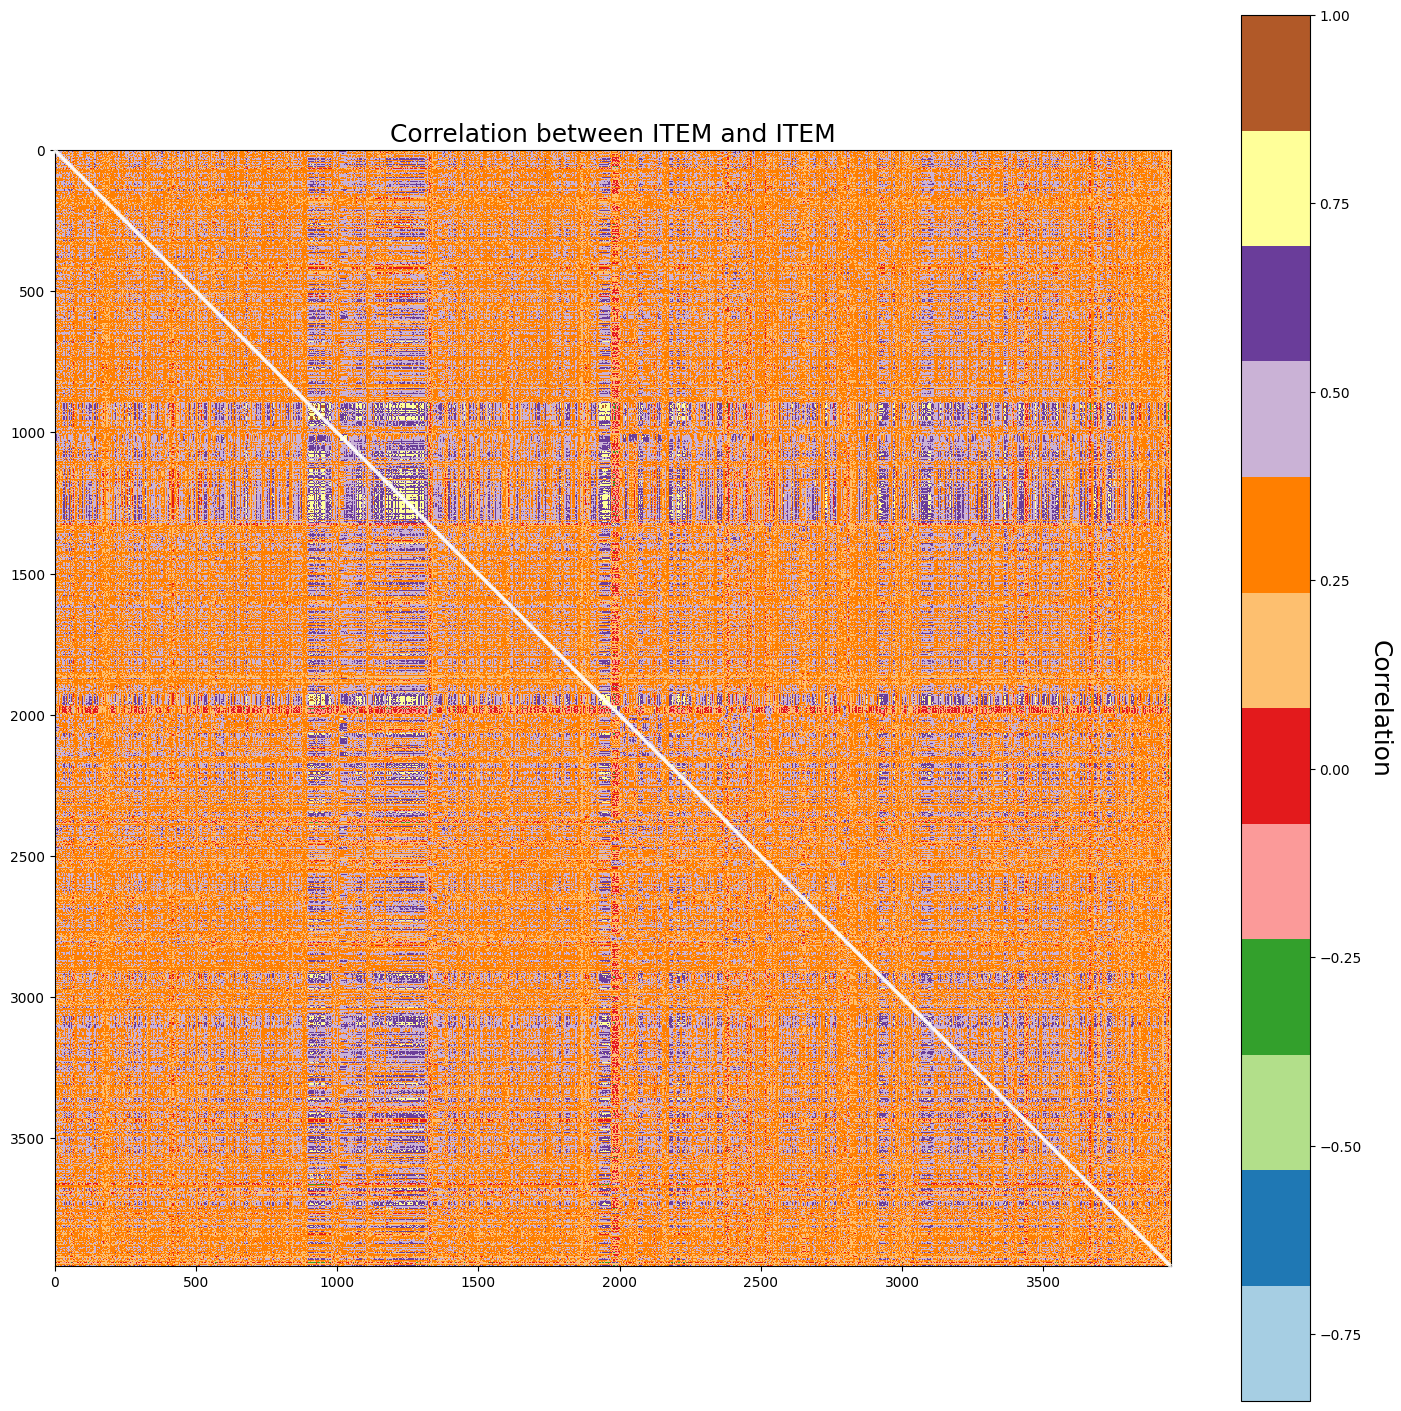

In [19]:
#Let's build correlation matrix

np_items = np.array(movie_cos_simiraity)
np_items = np.corrcoef(np_items)

fig, ax = plt.subplots(figsize=(18,18))
heatmap = ax.imshow(np_items, cmap='Paired')
for i in range(np_items.shape[0]):
    ax.text(i, i, "1.0", ha="center", va="center", color="white",
            fontsize=2, fontweight='light')
cbar = ax.figure.colorbar(heatmap, ax=ax)
cbar.ax.set_ylabel('Correlation', rotation=-90, va="bottom", fontsize=18)
plt.title('Correlation between ITEM and ITEM', fontsize=18)
plt.show()

In [20]:
#Find film with minimum correlation movies
import pandas as pd

np_items = pd.DataFrame(np_items)
min_corr = np_items.min().min()

min_corr_row = np_items[np_items == min_corr].stack().index[0][0]
min_corr_col = np_items[np_items == min_corr].stack().index[0][1]

print(f"Minimum Correlation Coefficient: {min_corr}")
print(f"Correlation between {min_corr_row} and {min_corr_col}")

Minimum Correlation Coefficient: -0.838528146234458
Correlation between 823 and 2955


In [21]:
min_cor_two = None
for movie_id, movie_info in movies.items():
    if movie_id == 823:
        min_cor_two = {movie_id: movie_info}
        print(min_cor_two)
    elif movie_id == 2955:
        min_cor_two = {movie_id: movie_info}
        print(min_cor_two)

{823: {'Title': 'Collectionneuse, La (1967)', 'Genres': ['Drama']}}
{2955: {'Title': 'Penitentiary II (1982)', 'Genres': ['Drama']}}


In [22]:
correlation_totals = np_items.abs().sum(axis=1)

min_corr_row = correlation_totals.idxmin()

print(f"The row with the minimum total correlation is '{min_corr_row}' with a total correlation value of {correlation_totals[min_corr_row]}")

The row with the minimum total correlation is '1796' with a total correlation value of 704.8916744137321


In [23]:
min_cor_movie = None
for movie_id, movie_info in movies.items():
    if movie_id == 1796:
        min_cor_movie = {movie_id: movie_info}
        print(min_cor_movie)


{1796: {'Title': "In God's Hands (1998)", 'Genres': ['Action', 'Drama']}}


In [25]:
#figure out what id missing in 'Movies' and if whether it have influence on the results

with zipfile.ZipFile('/content/ml-1m.zip', "r") as zi:
    with zi.open("ml-1m/movies.dat") as h:
        movies_id = []
        for line in h:
            ID, T, G = line.decode('iso-8859-1').strip().split("::")
            movies_id.append(ID)

In [26]:
len(movies_id)
dir(movies_id)
movies_ids = []
for i in movies_id:
    i = int(i)
    movies_ids.append(i)


In [28]:
#Find wich variables is missing of
total_id = 3952
existing_id = set(movies_ids)
missing_id = [id for id in range(1, total_id + 1) if id not in existing_id]
print("Missing IDs:", missing_id)
type(missing_id), type(q)

Missing IDs: [91, 221, 323, 622, 646, 677, 686, 689, 740, 817, 883, 995, 1048, 1072, 1074, 1182, 1195, 1229, 1239, 1338, 1402, 1403, 1418, 1435, 1451, 1452, 1469, 1478, 1481, 1491, 1492, 1505, 1506, 1512, 1521, 1530, 1536, 1540, 1560, 1576, 1607, 1618, 1634, 1637, 1638, 1691, 1700, 1712, 1736, 1737, 1745, 1751, 1761, 1763, 1766, 1775, 1778, 1786, 1790, 1800, 1802, 1803, 1808, 1813, 1818, 1823, 1828, 1838, 3815]


(list, numpy.ndarray)

In [29]:
mask = np.zeros(q.shape[0], dtype=bool)
mask[missing_id] = True
rows_to_keep = ~mask
q_filtered = q[rows_to_keep]
q_filtered.shape

(3884, 10)

In [30]:
# CAlculate how many ids before Stars War was deleted
count_items = 0
for item in missing_id:

    if item < 1196:
        count_items += 1
        continue
    elif item >= 1196:
        break
print(count_items)

17


In [31]:
movie_cos_sim_filtered = cosine_similarity(q_filtered)
movie_cos_sim_filtered.shape

(3884, 3884)

In [32]:
movie_star_war_filter = movie_cos_sim_filtered[(1196-count_items)]
movie_star_sorted_filter = np.argsort(movie_star_war_filter)[::-1]

In [33]:
first_movies_filter = 10
print(f'Previous {first_movies_filter} movies least similar to Movie {movie_star_war_filter}:')
cosine_filter = []
for i in range(1, first_movies_filter + 1):
    similar_movie_index_filter = movie_star_sorted_filter[i]
    similarity_filter = movie_star_war_filter[similar_movie_index_filter]
    print(f'Movie {similar_movie_index_filter}: Similarity = {similarity_filter:.4f}')
    cosine_filter.append((similarity_filter))

Previous 10 movies least similar to Movie [0.66139005 0.90589833 0.81730857 ... 0.64824627 0.64386052 0.81881035]:
Movie 258: Similarity = 0.9967
Movie 1193: Similarity = 0.9808
Movie 1181: Similarity = 0.9768
Movie 1272: Similarity = 0.9709
Movie 2648: Similarity = 0.9661
Movie 1354: Similarity = 0.9646
Movie 3119: Similarity = 0.9597
Movie 589: Similarity = 0.9579
Movie 1223: Similarity = 0.9466
Movie 1180: Similarity = 0.9464


In [34]:
answer1_filter = sum(cosine_filter[:3])
print(answer1_filter)
print(answer1) #Answers match

2.9543195369287503
2.9543195369287503


In [35]:
#Check all films with strating 'Star Wars...'

search_prefix = 'Star Wars'

found_movi = {}
for movie_id, movie_info in movies.items():
    if movie_info['Title'].startswith(search_prefix):
        found_movi[movie_id] = movie_info

print(found_movi)

{260: {'Title': 'Star Wars: Episode IV - A New Hope (1977)', 'Genres': ['Action', 'Adventure', 'Fantasy', 'Sci-Fi']}, 1196: {'Title': 'Star Wars: Episode V - The Empire Strikes Back (1980)', 'Genres': ['Action', 'Adventure', 'Drama', 'Sci-Fi', 'War']}, 1210: {'Title': 'Star Wars: Episode VI - Return of the Jedi (1983)', 'Genres': ['Action', 'Adventure', 'Romance', 'Sci-Fi', 'War']}, 2628: {'Title': 'Star Wars: Episode I - The Phantom Menace (1999)', 'Genres': ['Action', 'Adventure', 'Fantasy', 'Sci-Fi']}}


We end up with several similar movies, one of which is not similar in title to "Star Wars....", but has more in common than a movie that came out a few decades later.

**Calculate number of estemated movies for two similar users, where one of them have the id=5472.**

In [36]:
users[5472]
rate = pd.DataFrame(ratings[5472])
rate

,0,1,2
0,2054,3,2000-06-04 17:17:36
1,2059,3,2000-06-01 22:53:01
2,588,3,2000-06-01 20:19:50
3,589,3,2000-06-01 20:41:44
4,1408,3,2000-06-01 20:25:15
...,...,...,...
312,2022,1,2000-06-01 20:35:32
313,1080,1,2000-06-04 16:41:05
314,552,2,2000-06-01 20:47:30
315,553,3,2000-06-01 20:06:27


In [37]:
rate2 = pd.DataFrame(ratings[5009])
rate2

,0,1,2
0,1,3,2000-07-03 01:01:52
1,593,1,2000-07-03 00:34:08
2,3028,5,2000-07-03 00:36:50
3,3035,4,2000-07-03 01:01:52
4,908,5,2000-07-03 00:36:50
...,...,...,...
58,3704,4,2000-07-03 02:08:20
59,2791,4,2000-07-03 00:56:19
60,2797,4,2000-07-03 01:09:01
61,3751,5,2000-07-03 00:56:19


In [38]:
p.shape

(6041, 10)

In [39]:
user_cosine_sim = cosine_similarity(p)
user_cosine_sim.shape

(6041, 6041)

In [40]:
user_cos_id = user_cosine_sim[5472]
user_cos_id

array([0.76513037, 0.79281382, 0.75654192, ..., 0.78812275, 0.83205305,
       0.65907553])

In [42]:
user_sorted = np.argsort(user_cos_id)[::-1]
first_users = 10
print(f'Previous {first_users} users least similar to user {user_cos_id}:')

Previous 10 users least similar to user [0.76513037 0.79281382 0.75654192 ... 0.78812275 0.83205305 0.65907553]:


In [43]:
for i in range(0, first_users + 1):
    similar_user_idx = user_sorted[i]
    similarity_user = user_cos_id[similar_user_idx]
    print(f'User {similar_user_idx}: Similarity = {similarity_user:.5f}')

User 5472: Similarity = 1.00000
User 5009: Similarity = 0.94541
User 587: Similarity = 0.94522
User 4265: Similarity = 0.94474
User 2110: Similarity = 0.94340
User 442: Similarity = 0.94082
User 2927: Similarity = 0.93993
User 61: Similarity = 0.93780
User 2427: Similarity = 0.93676
User 883: Similarity = 0.93638
User 713: Similarity = 0.93108


In [45]:
ratings[5472]

[(2054, 3, datetime.datetime(2000, 6, 4, 17, 17, 36)),
 (2059, 3, datetime.datetime(2000, 6, 1, 22, 53, 1)),
 (588, 3, datetime.datetime(2000, 6, 1, 20, 19, 50)),
 (589, 3, datetime.datetime(2000, 6, 1, 20, 41, 44)),
 (1408, 3, datetime.datetime(2000, 6, 1, 20, 25, 15)),
 (2065, 2, datetime.datetime(2000, 6, 1, 20, 24)),
 (592, 4, datetime.datetime(2000, 6, 1, 20, 10, 53)),
 (594, 5, datetime.datetime(2000, 6, 4, 16, 52, 41)),
 (595, 3, datetime.datetime(2000, 6, 1, 22, 51, 50)),
 (596, 4, datetime.datetime(2000, 6, 1, 20, 22, 8)),
 (597, 2, datetime.datetime(2000, 6, 1, 20, 15, 18)),
 (1422, 2, datetime.datetime(2000, 6, 1, 23, 0, 34)),
 (3028, 3, datetime.datetime(2000, 6, 1, 20, 12, 38)),
 (3029, 2, datetime.datetime(2000, 6, 1, 20, 26, 42)),
 (2081, 4, datetime.datetime(2000, 6, 4, 16, 59, 16)),
 (1429, 3, datetime.datetime(2000, 6, 4, 16, 58, 21)),
 (2089, 3, datetime.datetime(2000, 6, 1, 20, 29, 19)),
 (3030, 4, datetime.datetime(2000, 6, 4, 16, 37, 21)),
 (3039, 2, datetime.date

In [46]:
ratings[5009]

[(1, 3, datetime.datetime(2000, 7, 3, 1, 1, 52)),
 (593, 1, datetime.datetime(2000, 7, 3, 0, 34, 8)),
 (3028, 5, datetime.datetime(2000, 7, 3, 0, 36, 50)),
 (3035, 4, datetime.datetime(2000, 7, 3, 1, 1, 52)),
 (908, 5, datetime.datetime(2000, 7, 3, 0, 36, 50)),
 (910, 4, datetime.datetime(2000, 7, 3, 0, 56, 19)),
 (912, 5, datetime.datetime(2000, 7, 3, 1, 12, 46)),
 (914, 5, datetime.datetime(2000, 7, 3, 1, 14, 45)),
 (920, 5, datetime.datetime(2000, 7, 3, 1, 14, 45)),
 (940, 5, datetime.datetime(2000, 7, 3, 0, 51, 15)),
 (3088, 5, datetime.datetime(2000, 7, 3, 1, 3, 36)),
 (951, 4, datetime.datetime(2000, 7, 3, 1, 4, 59)),
 (969, 5, datetime.datetime(2000, 7, 3, 0, 43, 20)),
 (3421, 3, datetime.datetime(2000, 7, 3, 0, 54, 52)),
 (2804, 5, datetime.datetime(2000, 7, 3, 1, 2, 51)),
 (260, 4, datetime.datetime(2000, 7, 3, 0, 44, 49)),
 (276, 1, datetime.datetime(2000, 7, 3, 0, 57, 11)),
 (1136, 4, datetime.datetime(2000, 7, 3, 1, 0, 14)),
 (1148, 5, datetime.datetime(2000, 7, 3, 0, 58, 1

In [47]:
count_oneuser = 0
count_twouser = 0
for id_one, number_of_rate in ratings.items():
    if id_one == 5472:
        for k in number_of_rate:
            count_oneuser += 1
        print('Count of one:', count_oneuser)
    elif id_one == 5009:
        for k in number_of_rate:
            count_twouser += 1
        print('Count of two:', count_twouser)
print('Total number of watched movies:', count_oneuser+count_twouser)

Count of two: 63
Count of one: 317
Total number of watched movies: 380


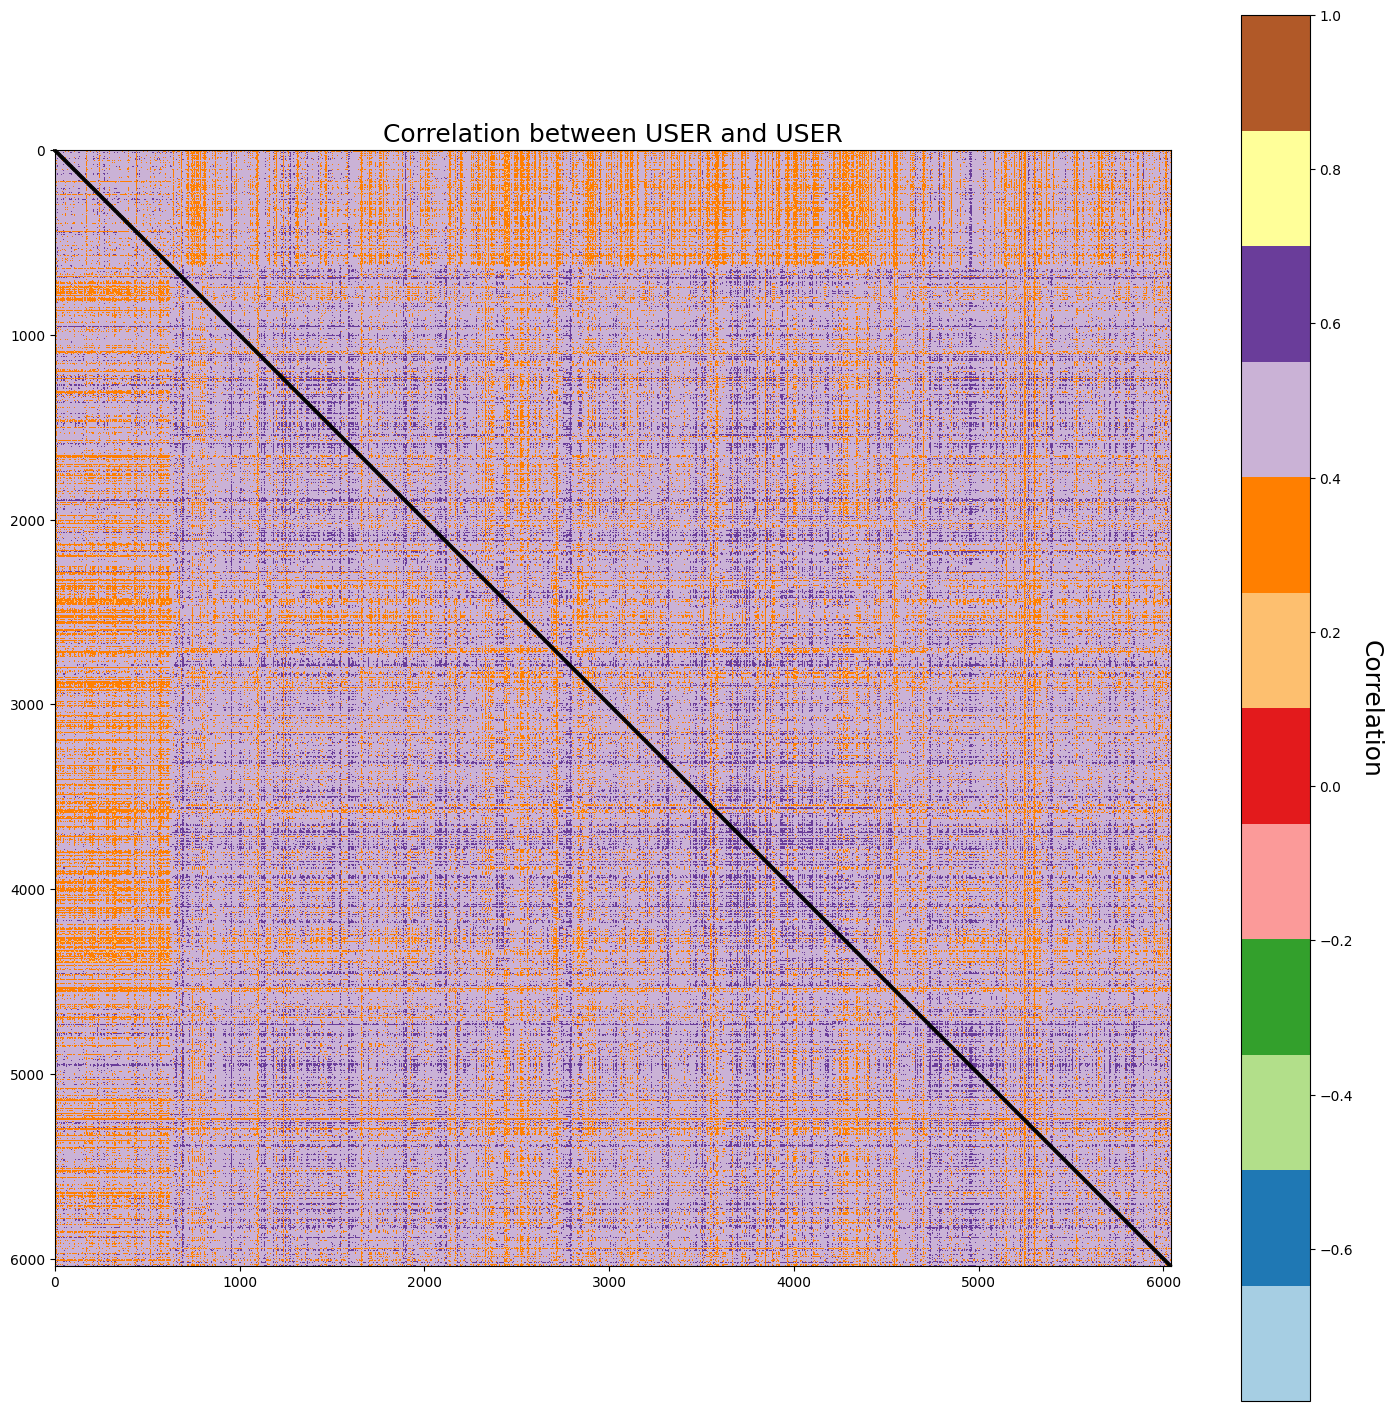

In [48]:
#Build correlation matrix

np_user = np.corrcoef(np.array(user_cosine_sim))
np_user = pd.DataFrame(np_user)

fig, ax = plt.subplots(figsize=(18,18))
heatmap = ax.imshow(np_user, cmap='Paired')
for i in range(np_user.shape[0]):
    ax.text(i, i, "1.0", ha="center", va="center", color="black",
            fontsize=2, fontweight='light')
cbar = ax.figure.colorbar(heatmap, ax=ax)
cbar.ax.set_ylabel('Correlation', rotation=-90, va="bottom", fontsize=18)
plt.title('Correlation between USER and USER', fontsize=18)
plt.show()